In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
from vice.yields.presets import JW20
import numpy as np
import math as m
import sys
sys.path.append("..")
from utils import exponential
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [8]:
raw = np.genfromtxt("../mocksamples/fiducial_offset4.dat")
data = vice.dataframe({})
data["[fe/h]"] = [row[0] for row in raw]
data["[o/fe]"] = [row[2] for row in raw]
# data["age"] = len(data["[fe/h]"]) * [float("nan")]
data["age"] = [10**row[4] for row in raw]

In [10]:
raw_chain = np.genfromtxt("../mocksamples/fiducial_offset4_wyields_5000.out")
mcmc_chain = {}
mcmc_chain["tau_in"] = [row[0] for row in raw_chain]
mcmc_chain["tau_star"] = [row[1] for row in raw_chain]
mcmc_chain["eta"] = [row[2] for row in raw_chain]
mcmc_chain["logp"] = [row[-1] for row in raw_chain]
true_values = {
    "tau_in": 2,
    "tau_star": 10,
    "eta": 25
}
max_idx = mcmc_chain["logp"].index(max(mcmc_chain["logp"]))

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
<ipython-input-18-291b43708a1b>:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


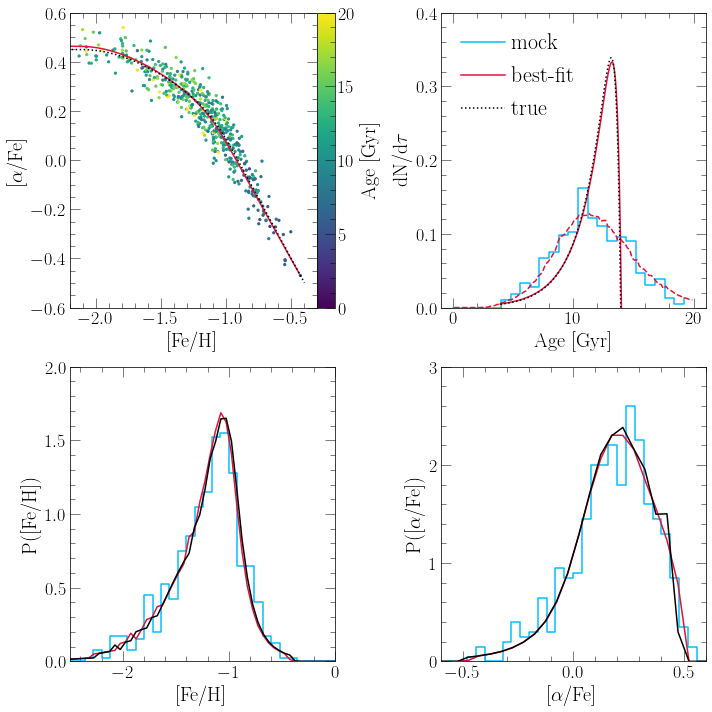

In [18]:
vice.yields.ccsne.settings['o'] = 0.0219 / 3
vice.yields.ccsne.settings['fe'] = 0.0017 / 3
vice.yields.sneia.settings['fe'] = 0.0025 / 3

fig = plt.figure(figsize = (10, 10))
axes = 2 * [None]
for i in range(len(axes)):
    axes[i] = 2 * [None]
    for j in range(len(axes[i])):
        axes[i][j] = fig.add_subplot(221 + 2 * i + j)
        
axes[0][0].set_xlabel("[Fe/H]")
axes[0][0].set_ylabel(r"[$\alpha$/Fe]")
axes[0][0].set_xlim([-2.2, -0.3])
axes[0][0].set_ylim([-0.6, 0.6])

duration = 10.06
with vice.singlezone(name = "bestfit") as sz:
    sz.func = exponential(timescale = 2.05)
    sz.mode = "ifr"
    sz.elements = ["fe", "o"]
    sz.Mg0 = 0
    sz.nthreads = 2
    sz.tau_star = 14.74 / 3
    sz.eta = 36.50 / 3
    bfout = sz.run(np.linspace(0, duration, int(100 * duration)), overwrite = True, capture = True)
    axes[0][0].plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"],
        c = named_colors()["crimson"], label = "best-fit")

kwargs = {
    "s": 5,
#     "c": named_colors()["black"],
    "c": data["age"],
    "vmin": 0,
    "vmax": 20,
    "cmap": "viridis"
}
mockout = vice.output("../mock")
# axes[0][0].scatter(data["[fe/h]"], data["[o/fe]"], c = named_colors()["black"], s = 5)
sc = axes[0][0].scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
axes[0][0].plot(mockout.history["[fe/h]"], mockout.history["[o/fe]"],
    c = named_colors()["black"], linestyle = ':', label = "actual")
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0.0, orientation = "vertical")
cbar.set_label("Age [Gyr]", labelpad = 5)
cbar.set_ticks(range(0, 25, 5))

axes[0][1].set_xlabel(r"Age [Gyr]")
axes[0][1].set_ylabel(r"dN/d$\tau$")
axes[0][1].set_xlim([-1, 21])
# axes[0][1].set_xlim([-1, 11])
axes[0][1].set_ylim([0, 0.4])
axes[0][1].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
hist, bins = np.histogram(data["age"], bins = 25, range = [0, 20], density = True)
axes[0][1].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
xvals = [_ + 14 - duration for _ in bfout.history["lookback"]]
dt = bfout.history["time"][1] - bfout.history["time"][0]
norm = sum(bfout.history["sfr"]) * dt
agedist = [_ / norm for _ in bfout.history["sfr"]]
axes[0][1].plot(xvals, agedist, c = named_colors()["crimson"], label = "best-fit")
norm = sum(bfout.history["sfr"])
sfrfrac = [_ / norm for _ in bfout.history["sfr"]]
indeces = np.random.choice(list(range(len(sfrfrac))), p = sfrfrac, size = int(1e5))
ages = [bfout.history["lookback"][_] + 14 - duration for _ in indeces]
ages = [m.log10(_) + np.random.normal(scale = 0.1) for _ in ages]
ages = [10**_ for _ in ages]
hist, bins = np.histogram(ages, bins = 100, range = [0, 20], density = True)
xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
axes[0][1].plot(xvals, hist, c = named_colors()["crimson"], linestyle = '--')

xvals = [_ + 14 - duration for _ in mockout.history["lookback"]]
norm = sum(mockout.history["sfr"]) * dt
agedist = [_ / norm for _ in mockout.history["sfr"]]
axes[0][1].plot(xvals, agedist, c = named_colors()["black"], label = "true", linestyle = ':')

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "fontsize": 22
}
leg = axes[0][1].legend(**kwargs)

axes[1][0].set_xlabel("[Fe/H]")
axes[1][0].set_ylabel("P([Fe/H])")
axes[1][0].set_xlim([-2.5, 0])
axes[1][0].set_ylim([0, 2])
axes[1][0].set_yticks([0, 0.5, 1.0, 1.5, 2.0])
hist, bins = np.histogram(data["[fe/h]"], bins = 50, range = [-3, 1], density = True)
axes[1][0].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
xvals = [(a + b) / 2 for a, b in zip(bfout.mdf["bin_edge_left"], bfout.mdf["bin_edge_right"])]
yvals = bfout.mdf["dn/d[fe/h]"]
axes[1][0].plot(xvals, yvals, c = named_colors()["crimson"], label = "best-fit")
yvals = mockout.mdf["dn/d[fe/h]"]
axes[1][0].plot(xvals, yvals, c = named_colors()["black"], label = "true")

axes[1][1].set_xlabel(r"[$\alpha$/Fe]")
axes[1][1].set_ylabel(r"P([$\alpha$/Fe])")
axes[1][1].set_xlim([-0.6, 0.6])
axes[1][1].set_ylim([0, 3])
axes[1][1].set_yticks([0, 1, 2, 3])
hist, bins = np.histogram(data["[o/fe]"], bins = 100, range = [-3, 1], density = True)
axes[1][1].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
yvals = bfout.mdf["dn/d[o/fe]"]
axes[1][1].plot(xvals, yvals, c = named_colors()["crimson"], label = "best-fit")
yvals = mockout.mdf["dn/d[o/fe]"]
axes[1][1].plot(xvals, yvals, c = named_colors()["black"], label = "true")

# kwargs = {
#     "loc": mpl_loc("upper left"),
#     "ncol": 1,
#     "fontsize": 22
# }
# leg = axes[1][1].legend(**kwargs)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.4, hspace = 0.2)
axes[0][0].set_position([
    axes[0][0].get_position().x0,
    axes[0][0].get_position().y0,
    axes[0][0].get_position().x1 - axes[0][0].get_position().x0 - 0.025,
    axes[0][0].get_position().y1 - axes[0][0].get_position().y0
])
cbar_ax.set_position([
    axes[0][0].get_position().x1,
    axes[0][0].get_position().y0,
    0.025,
    axes[0][0].get_position().y1 - axes[0][0].get_position().y0
])
# for ext in ["pdf", "jpeg"]: plt.savefig("./noages_offset4_distributions.%s" % (ext))
# for ext in ["pdf", "jpeg"]: plt.savefig("../someages_distributions.%s" % (ext))
# for ext in ["pdf", "jpeg"]: plt.savefig("./lowered_yields_distributions.%s" % (ext))
plt.show()

<ipython-input-10-de7b5df116a7>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


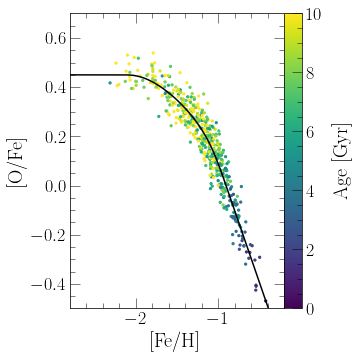

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel("[O/Fe]")
# ax.set_xlim([-1.7, 0.2])
# ax.set_ylim([-0.1, 0.5])
ax.set_xlim([-2.8, -0.2])
ax.set_ylim([-0.5, 0.7])
kwargs = {
    "s": 5,
#     "c": named_colors()["black"]
    "c": data["age"],
    "vmin": 0,
    "vmax": 10,
    "cmap": "viridis"
}
sc = ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
with vice.output("../mock") as out:
    ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()["black"])
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0.0, orientation = "vertical")
cbar.set_label("Age [Gyr]", labelpad = 10)
cbar.set_ticks(range(0, 12, 2))
plt.tight_layout()
plt.subplots_adjust(right = 0.8)
cbar_ax.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.05,
    ax.get_position().y1 - ax.get_position().y0
])
plt.savefig("../mocksamples/fiducial_ofe_feh.jpeg")
plt.show()